# Heart attack prediction 

In this notebook task I will be required to reformulate the problem and design a solution for  international healthcare provider, who is interested in whether machine learning could be used to help them develop a user-friendly model capable of detecting a stroke in patients. As a starting point, I would create an ensemble system (2 or more Machine Learning algorithms) which, given some data about a patient, can predict whether there is a stroke risk or not (or give the probability of a stroke)

The provided dataset which contains medical information of more than 600 persons. 

It also indicated that the dataset does require some pre-processing. In particular, removing any row in the dataset which contains a missing (NaN) value. 

While developing solution I've taken following steps into consideration when preparing the data.

• Concentrate on features which are well known to be contribute to the risk of a stroke. I've been provided with the following resources to help me choose the feature variables for my model.
https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/stroke-risk-factors-and-prevention

The task required to convert some of the numerical feature variables into categorical ones, I will be using label encoding and one hot encoding models. I've been provided with the following resources to help me choose the feature variables for my model.
https://medlineplus.gov/lab-tests/cholesterol-levels/

I've been provided with the following reserch paper to decide if after EDA phase I choose to consider Smoking rate as a feature variable. https://jamanetwork.com/journals/jama/article-abstract/192181

This notebook provides a good solution to this problem would predict (with reasonable accuracy) whether or not a new patient (i.e., one that is not in the dataset) was at high risk of a stroke. It is also important that the solution performs well for both well and at-risk persons.


In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [162]:
#Loading data into pandas Dataframe

data=pd.read_csv("Dataset_raw.csv")
data

,RANDID,TOTCHOL,AGE,SYSBP,DIABP,TIMEMI,CIGPDAY,TIME,STROKE,BMI
0,2448,196.0,52.0,100.0,62.0,6438.0,0.0,4628,2.0,NaN
1,6238,223.0,58.0,122.0,75.0,8766.0,0.0,4344,2.0,28.5
2,11252,232.0,58.0,131.0,70.0,8766.0,0.0,4285,2.0,24.6
3,11263,216.0,55.0,140.0,70.0,8766.0,0.0,4351,1.0,31.2
4,12806,208.0,57.0,127.0,75.0,8766.0,0.0,4289,2.0,22.0
...,...,...,...,...,...,...,...,...,...,...
615,1828967,201.0,59.0,149.0,80.0,8766.0,0.0,4285,1.0,30.5
616,1829622,212.0,61.0,187.0,105.0,8766.0,0.0,4287,1.0,22.7
617,1831641,306.0,70.0,170.0,85.0,8766.0,0.0,4365,1.0,24.1
618,1833245,159.0,66.0,170.0,96.0,8766.0,18.0,4295,1.0,24.0


#  converting some numerical feature variables into categorical 


In [164]:
def preprocess_input(df):
    df=df.copy()
     #Drop An identification number for each patient,TIME and Time of first angina/spasm columns
    df=df.drop('RANDID', axis=1)
    df=df.drop('TIMEMI', axis=1)
    df=df.drop('TIME', axis=1)
    
    #Removing NaN values
    df.dropna(how='any',inplace=True)
    
    #Converting numerical feature variables into categorical 
    
    category = pd.cut(df.STROKE,bins=[0,1,2],labels=['Less possibility','High possibility'])
    df.insert(6,'Stroke possibility',category)
    df=df.drop('STROKE', axis=1)

    category = pd.cut(df.TOTCHOL,bins=[0,200,239,390],labels=['Desirable','Borderline High','High'])
    df.insert(1,'Cholesterol Level',category)
    df=df.drop('TOTCHOL', axis=1)
    
    category = pd.cut(df.BMI,bins=[0,17,25,40,100],labels=['Under Weight','Healthy weight','Over weight','Obese'])
    df.insert(4,'Body Mass Index ',category)
    df=df.drop('BMI', axis=1)
    

    category = pd.cut(df.SYSBP,bins=[0,140,160,300],labels=['Normal','Borderline','Hypertension'])
    df.insert(2,'Heartbeat pressure',category)
    df=df.drop('SYSBP', axis=1)

    category = pd.cut(df.DIABP,bins=[0,90,100,150],labels=['Normal','Borderline','Hypertension'])
    df.insert(5,'Heartrelax pressure',category)
    df=df.drop('DIABP', axis=1)
    
#     df['CIGPDAY'].replace({'Non-Smoker':0})
#     category = pd.cut(df.CIGPDAY,bins=[0,1,9,19,80],labels=['Non-Smoker','1-9 Cig/day','10-19 Cig/day','>20 cig/day'])
#     df.insert(3,'Smoking Category',category)
#     df=df.drop('CIGPDAY', axis=1)
    
    return df

categorical_features=preprocess_input(data)
categorical_features

,Cholesterol Level,AGE,Heartbeat pressure,Body Mass Index,Heartrelax pressure,CIGPDAY,Stroke possibility
1,Borderline High,58.0,Normal,Over weight,Normal,0.0,High possibility
2,Borderline High,58.0,Normal,Healthy weight,Normal,0.0,High possibility
3,Borderline High,55.0,Normal,Over weight,Normal,0.0,Less possibility
4,Borderline High,57.0,Normal,Healthy weight,Normal,0.0,High possibility
5,Desirable,64.0,Borderline,Over weight,Normal,18.0,Less possibility
...,...,...,...,...,...,...,...
614,Desirable,53.0,Normal,Over weight,Normal,0.0,High possibility
615,Borderline High,59.0,Borderline,Over weight,Normal,0.0,Less possibility
616,Borderline High,61.0,Hypertension,Healthy weight,Hypertension,0.0,Less possibility
617,High,70.0,Hypertension,Healthy weight,Normal,0.0,Less possibility


In [165]:
categorical_features['CIGPDAY'].unique()

array([ 0., 18., 30., 20.,  3., 10., 40.,  5.,  4.,  1., 15.,  6., 16.,
       25., 12.,  8.,  7., 35.,  9.,  2.])

In [166]:
data.dropna(how='any',inplace=True)

# Feature selection

In [167]:
#Spilt df into X and Y
y=data['STROKE'] # y will be our target
x=data.drop('STROKE',axis=1) # x will be our features

#Train-test spilt
x_train, x_test, y_train, y_test= train_test_split(x,y, train_size=0.3, random_state=0)

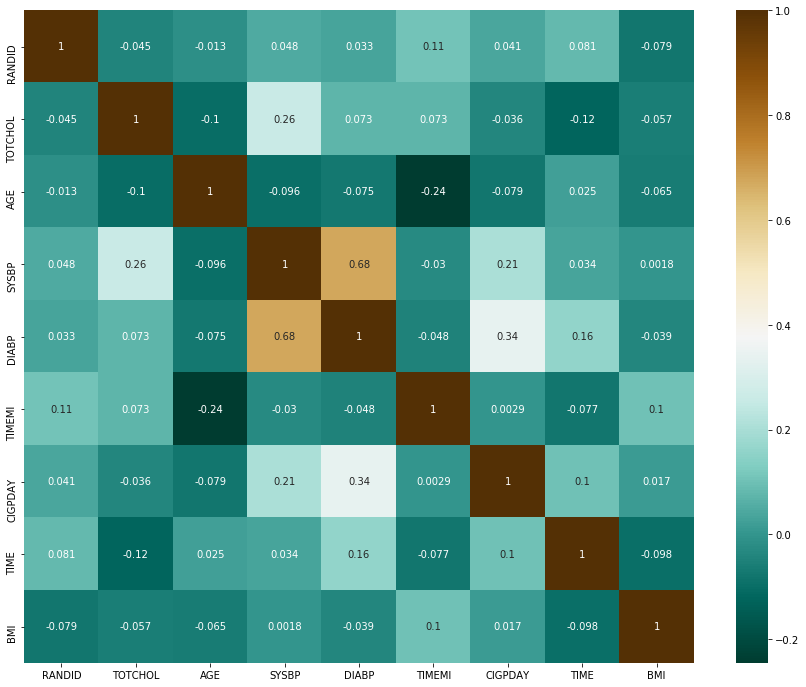

In [168]:
#Using Pearson Correlation
import seaborn as sns
plt.figure(figsize=(15,12))
cor = x_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.BrBG_r)
plt.show()

In [169]:
# Creating a correlation function, with we can select highly correlated features and 
# It will remove the first feature that is coorealted with anyother feature

def correlation(data, threshold):
    col_corr=set() # set all the names of correlated columns
    corr_matrix= data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i,j])> threshold:
                colname=corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                
        return col_corr        

In [170]:
corr_features= correlation(x_train, 0.4)
len(set(corr_features))


0

In [171]:
corr_features

set()

In [172]:
x_train.drop(corr_features,axis=1)
x_test.drop(corr_features,axis=1)

,RANDID,TOTCHOL,AGE,SYSBP,DIABP,TIMEMI,CIGPDAY,TIME,BMI
418,1252452,195.0,49.0,104.0,69.0,8766.0,0.0,4350,26.4
136,459386,300.0,54.0,160.0,70.0,7163.0,0.0,4295,27.4
216,688490,232.0,48.0,161.0,78.0,8766.0,0.0,4450,26.1
249,779250,239.0,67.0,148.0,80.0,8766.0,0.0,4321,25.6
87,272194,190.0,76.0,120.0,74.0,7796.0,0.0,4387,22.0
...,...,...,...,...,...,...,...,...,...
209,669084,226.0,71.0,129.0,78.0,8766.0,0.0,4308,25.0
240,767169,164.0,65.0,146.0,71.0,8766.0,0.0,4352,26.6
266,813079,226.0,62.0,146.0,77.0,5793.0,0.0,4306,27.8
68,207401,269.0,66.0,160.0,82.0,5496.0,0.0,4508,16.8


In [173]:
# def preprocess_input(df):
#     df=df.copy()
    
#     #Drop An identification number for each patient,TIME and Time of first angina/spasm columns
#     df=df.drop('RANDID', axis=1)
#     df=df.drop('TIMEMI', axis=1)
#     df=df.drop('TIME', axis=1)
    
#     df.dropna(how='any',inplace=True)
#     return df

# x_data=preprocess_input(data)
# x_data

In [174]:
#Scalling
scaler= StandardScaler()
scaler.fit(x_train)
x_train=pd.DataFrame(scaler.transform(x_train))
x_test=pd.DataFrame(scaler.transform(x_test))

x_train.var()

0    1.00565
1    1.00565
2    1.00565
3    1.00565
4    1.00565
5    1.00565
6    1.00565
7    1.00565
8    1.00565
dtype: float64

# Training models

In [175]:
models={
    "LogisticRegression"                  :LogisticRegression(),
    "RandomForest"                        :RandomForestClassifier(),
    "NeuralNetwork"                       :MLPClassifier(),
    "DecisionTree"                        :DecisionTreeClassifier(),
    "Support Vector Machine (Linear kernel)":LinearSVC(),
    "Support Vector machine (RBF Kernel)"  :SVC(),
    "K-Nearest Neighbors"                  :KNeighborsClassifier(),
    "Gradient Boosting"                    :GradientBoostingClassifier()
    
}

for name, model in models.items():
    model.fit(x_train,y_train)
    print(name+ " Trained")

LogisticRegression Trained
RandomForest Trained
NeuralNetwork Trained
DecisionTree Trained
Support Vector Machine (Linear kernel) Trained
Support Vector machine (RBF Kernel) Trained
K-Nearest Neighbors Trained
Gradient Boosting Trained


# Model Performance

In [176]:
# print("Model performance\n---------------------")
for name, model in models.items():
    y_pred=model.predict(x_test)
    print( 
        "\n"+ name + " Accuracy: {:.3f}%\n\t\t\t F1-Score: {:.5f}"\
        .format(accuracy_score(y_test,y_pred)*100, f1_score(y_test, y_pred))
    )

# print("Model performance\n---------------------")
# for name, model in models.items():
#     y_pred=model.predict(x_test)
#     print(name+ " Accuracy".format(accuracy_score(y_test,y_pred,  f1_score(y_test, y_pred)))
#     #print(name+ "F1-Score"+ f1_score(y_test, y_pred))


LogisticRegression Accuracy: 87.321%
			 F1-Score: 0.87646

RandomForest Accuracy: 90.431%
			 F1-Score: 0.90698

NeuralNetwork Accuracy: 87.560%
			 F1-Score: 0.87850

DecisionTree Accuracy: 81.340%
			 F1-Score: 0.82743

Support Vector Machine (Linear kernel) Accuracy: 87.321%
			 F1-Score: 0.87760

Support Vector machine (RBF Kernel) Accuracy: 87.081%
			 F1-Score: 0.87019

K-Nearest Neighbors Accuracy: 81.579%
			 F1-Score: 0.79790

Gradient Boosting Accuracy: 90.191%
			 F1-Score: 0.90531


# Ensemble learning

# Bagging Classifier 

In [177]:
#Bragging (Bootstrap aggregation)

# creating bragging classifer with models
bg = BaggingClassifier (RandomForestClassifier(), max_samples=0.5, max_features=1.0, n_estimators= 20) 
bg.fit(x_test,y_test)


BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
     

In [178]:
bg.score(x_test,y_test)

0.9497607655502392

In [179]:
bg.score(x_train,y_train)

0.9101123595505618

# Boosting classifier

In [180]:
#Boosting 
# using Ada Boost
ada = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators= 10, learning_rate=1)
ada.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [181]:
ada.score(x_test,y_test)

0.80622009569378

    It is same as Random forrest model accuracy, we can find out if our model is over fitting since the score on training dataset is 100% , the model did not find any point in our data where there was error and stopped the process, so we get the same 90% accuracy as of Random Forrest model but if we choose a classifer which does not overfit data like Decision Tree does boosting can well boost the accuracy of our model by a great factor and if we see Bagging hasn't overfitted the model if we see training dataset score, so we can say boosting help us in reducing the overfitting of the model, so we can implement ensemble model to have multiple ML models, so this can be done through voting classifier.

In [182]:
ada.score(x_train,y_train)

1.0

In [189]:
# # Voting classifer ( Also known as Stacking)
# # we are choosing models with high accuracy for voting
# vc = VotingClassifier(estimators=[('lr',LogisticRegression),('tr',DecisionTreeClassifier),('ne',MLPClassifier)],voting='hard')
# vc.fit(x_train.iloc[1:4000],y_train.iloc[1:4000]) # reducing size of data and train it as it took a lot of time to compute
# #vc.fit(x_train,y_train)
# vc.score(x_test,y_test)

# voting classifier

In [196]:
# Also known as Stacking

clf1=LogisticRegression(random_state=1)
clf2=RandomForestClassifier(random_state=1)
clf3=DecisionTreeClassifier()

print('5-fold cross validation:\n')

labels = ['Logistic Regression','Random Forest','Decision Tree']

for clf, label in zip([clf1, clf2, clf3], labels):
    
    scores= model_selection.cross_val_score(clf,x,y,cv=5,scoring='accuracy')
    
    print("Accuracy :%0.2f (+/- %0.2f) [%s]"
          
         %(scores.mean(),scores.std(),label))
    

5-fold cross validation:

Accuracy :0.82 (+/- 0.04) [Logistic Regression]
Accuracy :0.91 (+/- 0.02) [Random Forest]
Accuracy :0.87 (+/- 0.03) [Decision Tree]


In [197]:
#Creating voting class for hard voting
voting_hard=VotingClassifier(estimators=[(labels[0], clf1), (labels[1], clf2), (labels[2], clf3)], voting='hard')

In [198]:
#Creating voting class for soft voting
voting_soft=VotingClassifier(estimators=[(labels[0], clf1), (labels[1], clf2), (labels[2], clf3)], voting='soft')

Diffrence between hard and soft voting is,hard voting is consider the class output and then takes the majority, where as soft voting takes the probality score and then avarges out the probalities.
a value above threshold is classifed as one and value below threshold of probability score is classifed as zero.

In [200]:
#creating list of lables 
new_labels= ['Logistic Regression','Random Forest','Decision Tree','voting_hard', 'voting_soft']

for (clf,label) in zip([clf1, clf2, clf3, voting_hard, voting_soft],new_labels):
    
    scores= model_selection.cross_val_score(clf,x,y,cv=5, scoring='accuracy')
    
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
         % (scores.mean(), scores.std(), label))

Accuracy: 0.82 (+/- 0.04) [Logistic Regression]
Accuracy: 0.91 (+/- 0.02) [Random Forest]
Accuracy: 0.86 (+/- 0.03) [Decision Tree]
Accuracy: 0.90 (+/- 0.03) [voting_hard]
Accuracy: 0.89 (+/- 0.04) [voting_soft]


I find that my voting classifer hard and soft individually have an accuracy around 90% as compared to 82,91 and 86.
So here we can see weak learners which are individual classifers such as Logistic, Random forest and Decision tree, i could increse my accuracy by using  voting classifer to create a more robust and an accurate classifer.